# Forecasts and Predictions

__Project description:__

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. The task is to analyze them and come up with a customer retention strategy.

We will: 
- learn to predict the probability of churn (for the upcoming month) for each customer
- draw up typical user portraits: select the most outstanding groups and describe their main features
- analyze the factors that impact churn most and draw basic conclusions
- develop recommendations on how to improve customer service

## Exploratory data analysis (EDA)

In [1]:
# loading the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.metrics import silhouette_score
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
df = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
# looking at the genral info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
# changing datatype for month to end contract column
df.Month_to_end_contract = df.Month_to_end_contract.astype(np.int64)

In [5]:
# looking at the 1st 5 rows of the df
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


In [6]:
# rounding numerical values to 2 decimals
pd.options.display.float_format = '{:,.2f}'.format

In [7]:
# checking whether there are any missing values
df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [8]:
# checking whether there are any duplicates
df.duplicated().sum()

0

In [9]:
# looking at the mean values and standard deviation
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


In [10]:
# looking at the mean feature values in two groups: for those who left (churn) and for those who stayed
df.groupby(['Churn']).mean().T

Churn,0,1
gender,0.51,0.51
Near_Location,0.87,0.77
Partner,0.53,0.36
Promo_friends,0.35,0.18
Phone,0.90,0.90
Contract_period,5.75,1.73
Group_visits,0.46,0.27
Age,29.98,26.99
Avg_additional_charges_total,158.45,115.08
Month_to_end_contract,5.28,1.66


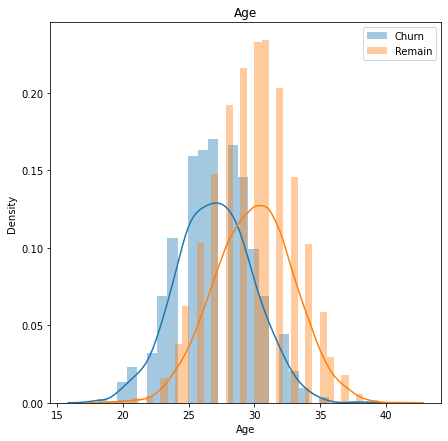

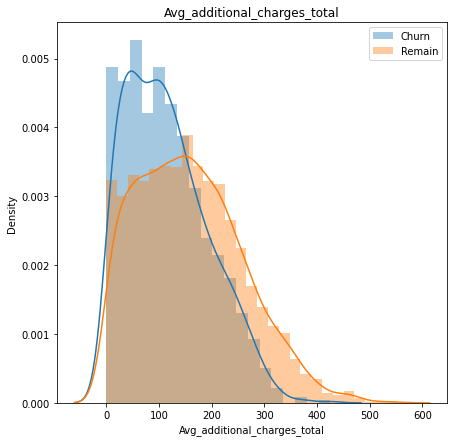

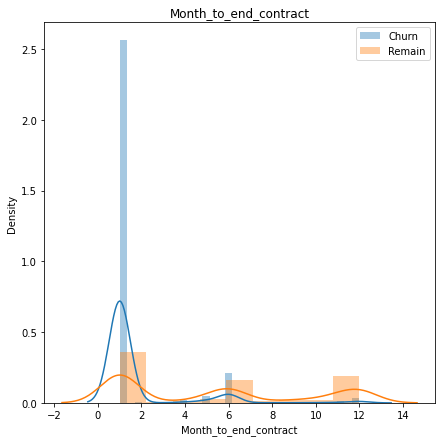

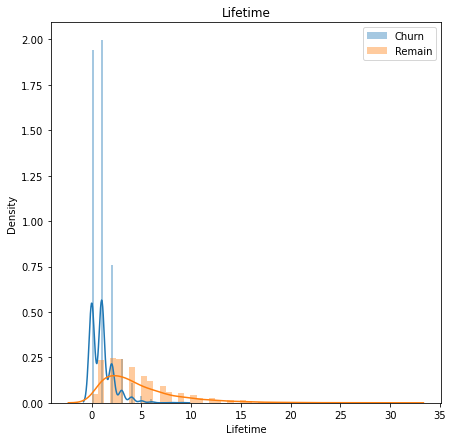

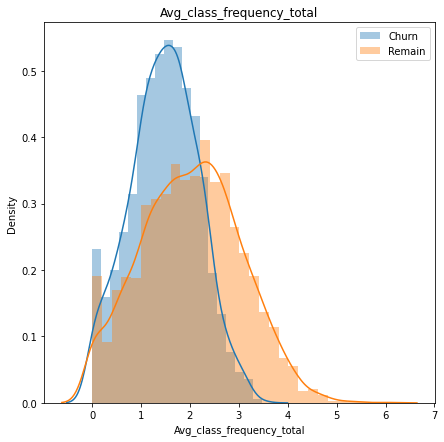

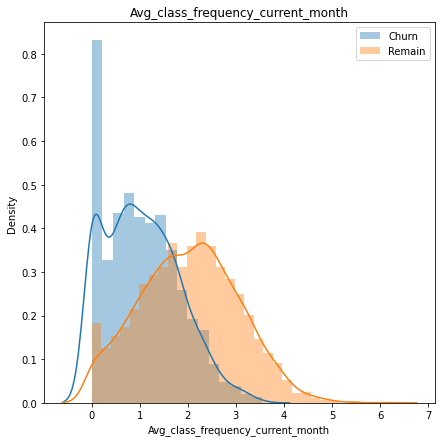

In [11]:
# plotting numerical feature distributions for those who left (churn) and those who stayed

df_numerical = df[['Age','Avg_additional_charges_total', 'Month_to_end_contract','Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']]

for column in df_numerical.columns:
    plt.figure(figsize=(7, 7))
    df.groupby('Churn')[column]

    sns.distplot(df.query('Churn==1')[column], label ='Churn')
    sns.distplot(df.query('Churn==0')[column], label ='Remain')
    plt.legend()
    plt.title(column);

It appears customers who are 30 years old and up, are more likely to remain and younger ones tend to churn.

Customers who spend more money on additional gym services tend to remain.

It appears high churn occurs when there's 1 month left of subscription, fewer churn when they have 5 or 6 months left.

It looks like those who have been in the gym for 5 months and up are more likely to stay.

Those who churn appear to go to the gym less times a week if at all than the retained customers, who often would visit 2, 3 even 4 or more times a week.


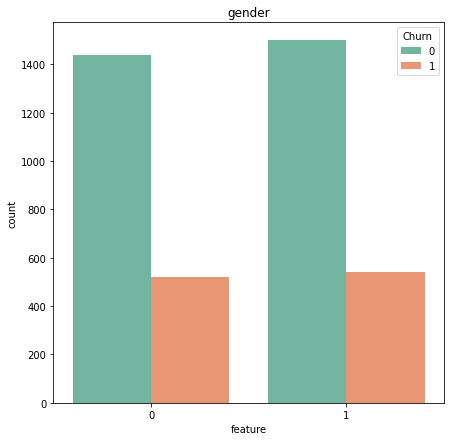

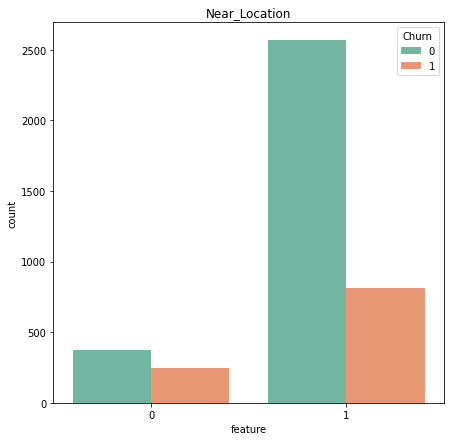

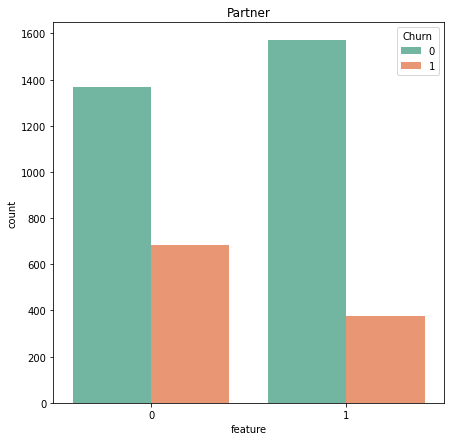

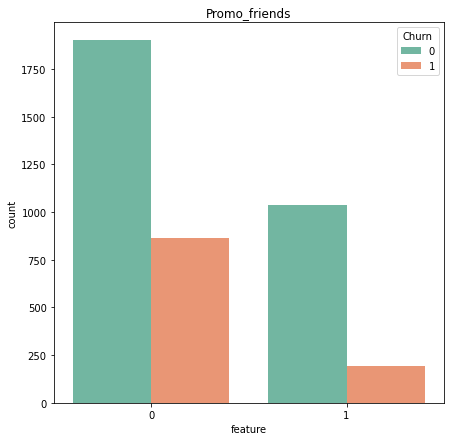

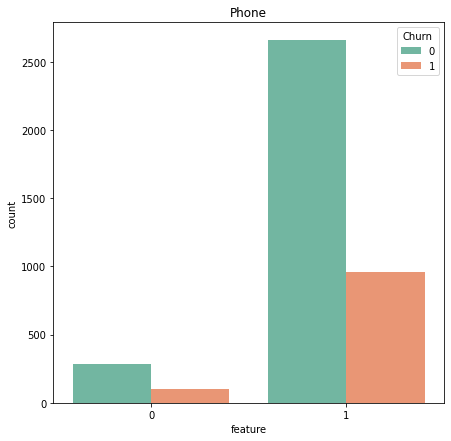

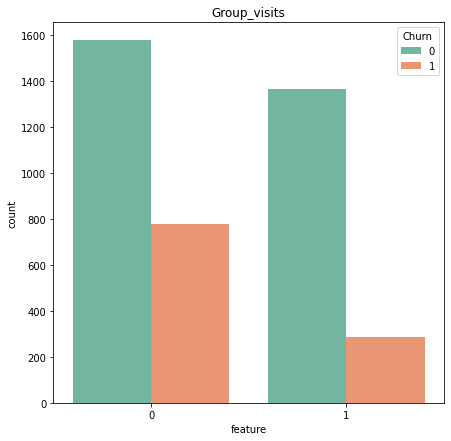

In [12]:
# building plots for categorical features
for column in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']:
    plt.figure(figsize=(7, 7))
    sns.countplot(x = df[column], hue='Churn', data=df, palette='Set2')
    plt.xlabel('feature')
    plt.title(column);

Customers who live near the gym appear more likely to keep visiting.

Customers who are employees of partner companies, and therefore receive discounts, appear to be more likely to be retained and the same goes for those who signed up through a "bring a friend" offer.

It also seems those who join group sessions are more likely to remain in the gym as well.

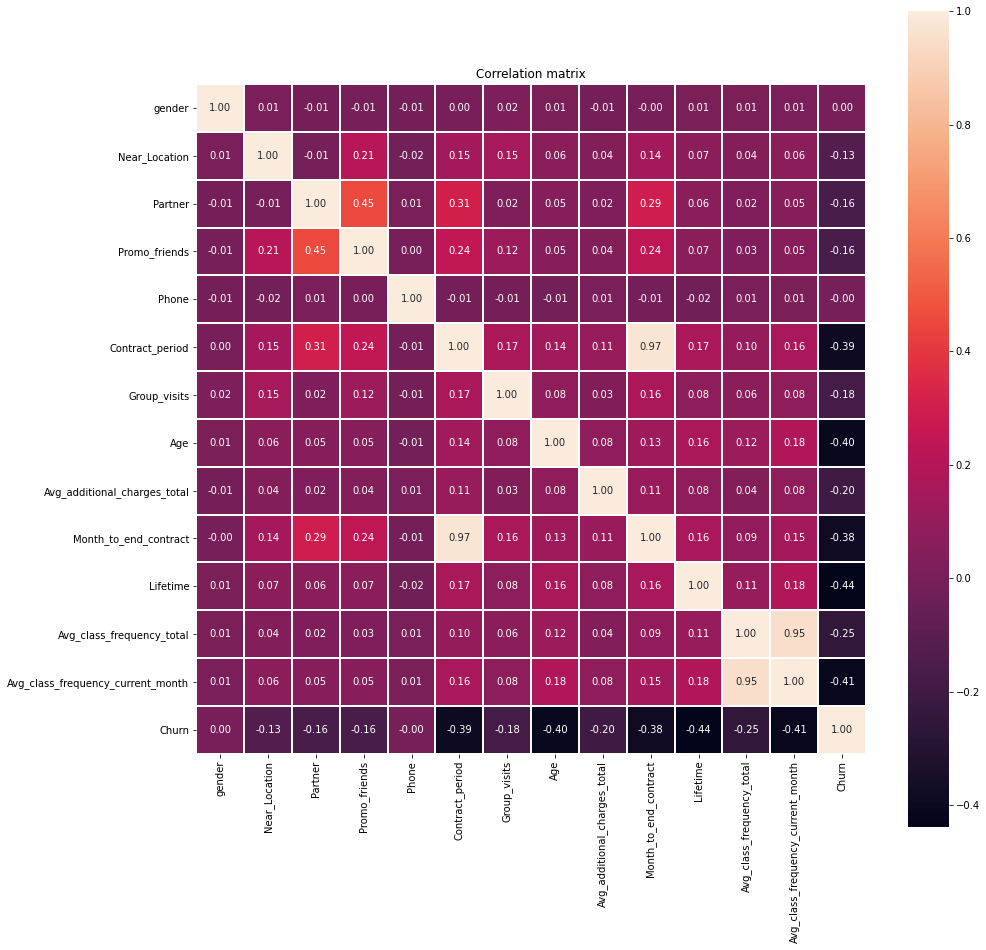

In [13]:
# building a correlation matrix
cm = df.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlation matrix')
sns.heatmap(cm, annot=True, square=True, fmt='.2f', linewidths=1, linecolor='white') 
plt.show()

It appears we have some features that point to multicollinearity - contract period and month to end contract, also, average class frequency total and average class frequency for current month.

Some significant correlations with the target variable (churn) are age, the time (in months) since the customer first came to the gym, average frequency of visits, contract period and also months remaining until the end of contract.

There is no observed correlation between phone, gender, and the target variable.

## Building a model to predict user churn

In [14]:
# removing multicollinear variables from the dataset
model_df = df.drop(['Month_to_end_contract', 'Avg_class_frequency_current_month'], axis=1)

In [15]:
# dividing the data into features (the X matrix) and a target variable (y)
X = model_df.drop('Churn', axis = 1)
y = model_df['Churn']

In [16]:
# looking at the ratio between the dataset classes
model_df['Churn'].value_counts() / model_df['Churn'].count()


0   0.73
1   0.27
Name: Churn, dtype: float64

In [17]:
# dividing the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [19]:
# creating a StandardScaler object and applying it to the train set
scaler = StandardScaler()
# training the scaler and transforming the matrix for the train set
X_train_st = scaler.fit_transform(X_train)
# applying standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

In [20]:
# defining the model's algorithm
model = LogisticRegression(random_state=0)
# training the model
model.fit(X_train_st, y_train)
# using the trained model to make predictions
lr_pred = model.predict(X_test_st)

In [21]:
print('Metrics for logistic regression:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_pred))) 
print('Precision: {:.2f}'.format(precision_score(y_test, lr_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_pred)))

Metrics for logistic regression:
Accuracy: 0.89
Precision: 0.80
Recall: 0.79
F1: 0.80


In [22]:
# defining the algorithm for logistic regression model Random Forest
rf_model = RandomForestRegressor(n_estimators = 100, random_state=0)
rf_model.fit(X_train_st, y_train)
# using the trained model to make predictions
rf_pred = rf_model.predict(X_test_st)

In [23]:
print('Metrics for random forest:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_pred.round()))) 
print('Precision: {:.2f}'.format(precision_score(y_test, rf_pred.round())))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_pred.round())))
print('F1: {:.2f}'.format(f1_score(y_test, rf_pred.round())))

Metrics for random forest:
Accuracy: 0.87
Precision: 0.78
Recall: 0.72
F1: 0.75


In [24]:
# defining the algorithm for the gradient boosting model
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 0)
# training the gradient boosting model
gb_model.fit(X_train_st, y_train)
# using the trained model to make predictions
gb_pred = gb_model.predict(X_test_st)

In [25]:
print('Metrics for gradient boosting:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, gb_pred))) 
print('Precision: {:.2f}'.format(precision_score(y_test, gb_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, gb_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, gb_pred)))

Metrics for gradient boosting:
Accuracy: 0.89
Precision: 0.81
Recall: 0.75
F1: 0.78


In [26]:
# defining the algorithm for the cat boost model
cat_model = CatBoostClassifier(n_estimators = 100, random_state = 0)
cat_model.fit(X_train_st, y_train)

cat_pred = cat_model.predict(X_test_st) 
cat_prob = cat_model.predict_proba(X_test_st)

Learning rate set to 0.13209
0:	learn: 0.6224080	total: 47.7ms	remaining: 4.72s
1:	learn: 0.5632143	total: 49.3ms	remaining: 2.42s
2:	learn: 0.5186689	total: 50.8ms	remaining: 1.64s
3:	learn: 0.4763397	total: 52.4ms	remaining: 1.26s
4:	learn: 0.4412174	total: 54.1ms	remaining: 1.03s
5:	learn: 0.4143407	total: 55.7ms	remaining: 872ms
6:	learn: 0.3904007	total: 57.3ms	remaining: 761ms
7:	learn: 0.3694508	total: 58.8ms	remaining: 676ms
8:	learn: 0.3524963	total: 60.2ms	remaining: 609ms
9:	learn: 0.3363690	total: 61.6ms	remaining: 555ms
10:	learn: 0.3212195	total: 63.1ms	remaining: 510ms
11:	learn: 0.3103612	total: 64.5ms	remaining: 473ms
12:	learn: 0.3003053	total: 66.1ms	remaining: 443ms
13:	learn: 0.2912977	total: 67.7ms	remaining: 416ms
14:	learn: 0.2833698	total: 69.2ms	remaining: 392ms
15:	learn: 0.2764018	total: 70.9ms	remaining: 372ms
16:	learn: 0.2695007	total: 72.5ms	remaining: 354ms
17:	learn: 0.2639436	total: 74.2ms	remaining: 338ms
18:	learn: 0.2590302	total: 75.8ms	remaining:

In [27]:
print('Metrics for cat boost:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, cat_pred))) 
print('Precision: {:.2f}'.format(precision_score(y_test, cat_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, cat_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, cat_pred)))

Metrics for cat boost:
Accuracy: 0.88
Precision: 0.78
Recall: 0.77
F1: 0.78


In [28]:
# using the trained model to make forecasts
probabilities = cat_model.predict_proba(X_test_st)[:,1]
#print(gb_model.predict_proba(X_test_st))

In [29]:
# setting the threshold
threshold = 0.3

# calculating predict on the basis of probabilities and the ratio between classes
custom_predictions = [0 if i<threshold else 1 for i in probabilities]

In [30]:
print('Metrics with custom threshold for cat boost:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, custom_predictions)))

Metrics with custom threshold for cat boost:
Accuracy: 0.89
Precision: 0.75
Recall: 0.87
F1: 0.80


The classes are imbalanced and therefore the accuracy is not a very useful metric.

However, precision metric works better in cases when there are imbalanced classes. In this case precision is higher when we use logistic regression and gradient boosting.

Recall also works well for problems with imbalanced classes. We've got highest recall with gradient boosting and cat boost.

And metrics with custom teshold show slightly different results - improved recall, but lower precision, however, F1 score suggests that the model is performing well in terms of both, precision and recall. Generally, the scores show the model with the custom treshold is performing quite well.

## Creating user clusters

In [31]:
# transforming the dataset
X_sc = scaler.fit_transform(X)

In [32]:
# building a matrix of distances based on the standardized feature matrix and plotting a dendrogram
X_sc = scaler.fit_transform(X)
linked = linkage(X_sc, method = 'ward') 

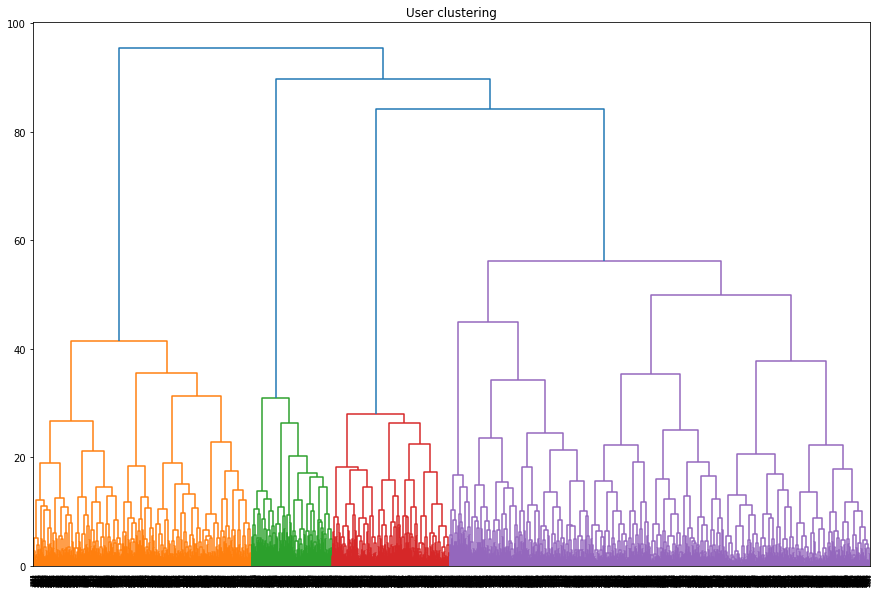

In [33]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('User clustering')
plt.show()

In the dendrogram we see 4 clusters and the purple one is quite big, however, it is not really surprising to see imbalances in the cluster sizes since the data is imbalanced.

In [34]:
# training the clustering model with the K-means algorithm
# setting number of cluseters to 5
km = KMeans(n_clusters = 5, random_state=0)
# predicting customer clusters
labels = km.fit_predict(X_sc)

In [35]:
print('Silhouette score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette score: 0.14


The silhouette score is quite low. The clustering may not be very clear and some objects could be in the wrong cluster.

In [36]:
# storing cluster labels into our dataset
model_df['cluster'] = labels

In [37]:
# looking at the new cluster column
model_df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn,cluster
0,1,1,1,1,0,6,1,29,14.23,3,0.02,0,4
1,0,1,0,0,1,12,1,31,113.20,7,1.92,0,3
2,0,1,1,0,1,1,0,28,129.45,2,1.86,0,2
3,0,1,1,1,1,12,1,33,62.67,2,3.21,0,1
4,1,1,1,1,1,1,0,26,198.36,3,1.11,0,1


In [38]:
# looking at number of users in each cluster
model_df.cluster.value_counts()

2    1132
1    1050
3     871
0     561
4     386
Name: cluster, dtype: int64

In [39]:
# looking at the mean feature values for clusters
model_df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
Near_Location,0.00,1.00,1.00,1.00,0.86
Partner,0.49,0.96,0.24,0.25,0.47
Promo_friends,0.08,0.89,0.06,0.08,0.31
Phone,1.00,1.00,1.00,1.00,0.00
Contract_period,3.03,7.66,2.82,4.53,4.78
Group_visits,0.24,0.46,0.00,1.00,0.43
Age,28.72,29.54,28.77,29.54,29.30
Avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
Lifetime,3.06,4.38,3.34,3.76,3.94


The 5 clusters appear to be distinguishable from each other.

Cluster 0: Highest churn rate, rather short contract periods, low group visits.

Cluster 1: Very low churn rate, customers located near the gym, significant partnership and via friend sign-ups. They also have longest contract periods and highest additional charges spent.

Cluster 2: Moderate churn rate, no group visits, shortest contract periods. Low friend / partnership sign-ups.

Cluster 3: Low churn rate, near the gym, very active class participation, moderate contract periods.

Cluster 4: Low churn rate, moderate contract periods and group visits, moderate partner / friend sign-ups.

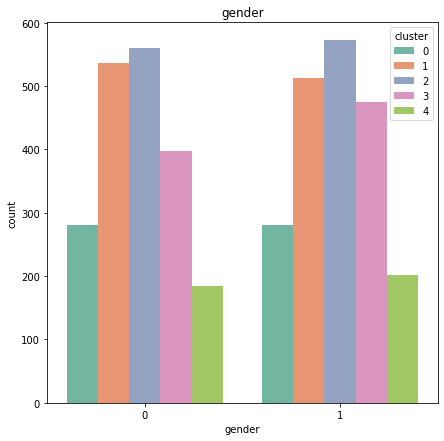

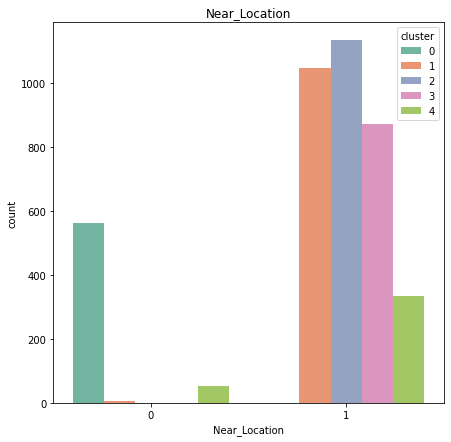

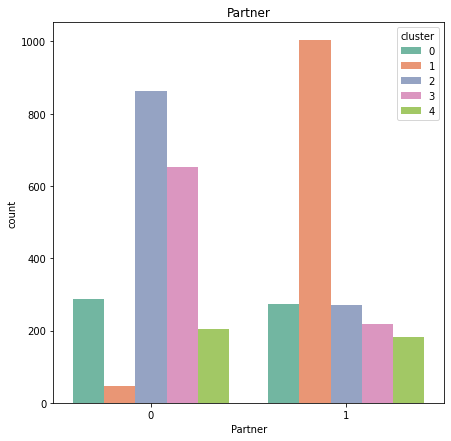

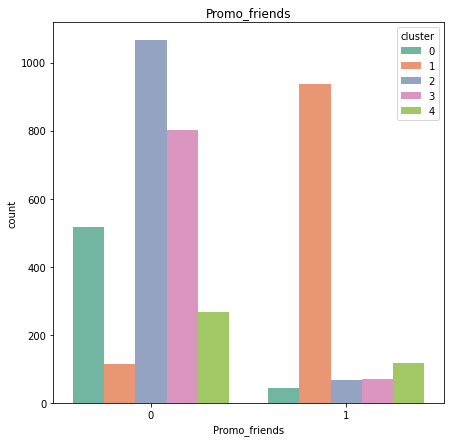

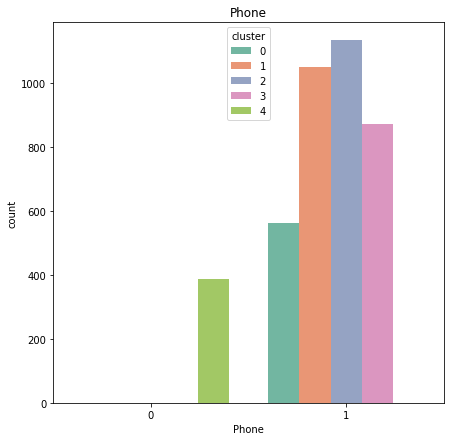

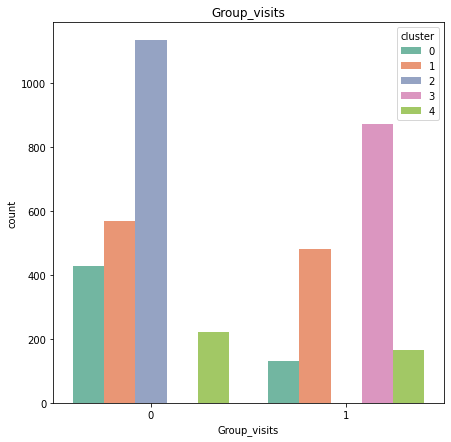

In [40]:
# plotting distributions of categorical features
for column in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']:
    plt.figure(figsize=(7, 7))
    sns.countplot(x = df[column], hue='cluster', data=model_df, palette = 'Set2')
    plt.title(column);

<Figure size 504x504 with 0 Axes>

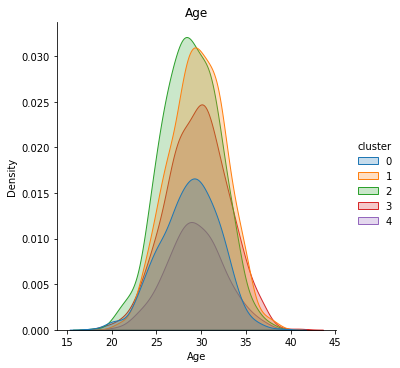

<Figure size 504x504 with 0 Axes>

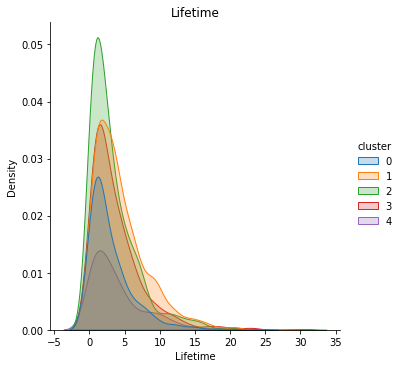

<Figure size 504x504 with 0 Axes>

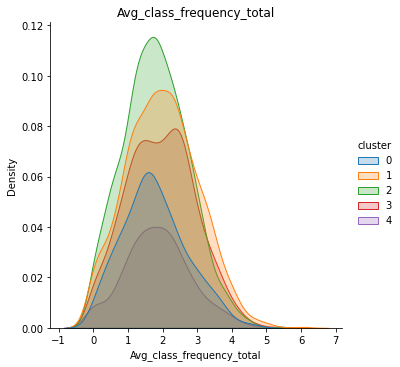

<Figure size 504x504 with 0 Axes>

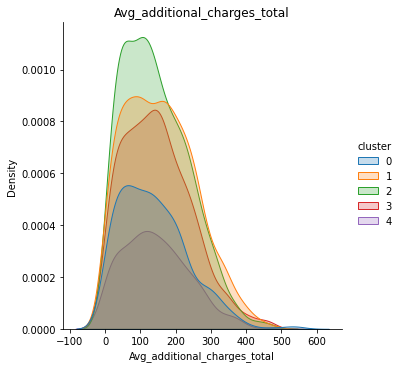

In [41]:
# plotting distributions of numerical features
for column in ['Age', 'Lifetime', 'Avg_class_frequency_total', 'Avg_additional_charges_total']:
    plt.figure(figsize=(7, 7))
    sns.displot(x = df[column], hue='cluster', data=model_df, kind='kde', fill=True, palette='tab10')
    plt.title(column);

In [42]:
model_df.groupby('cluster')['Churn'].mean()

cluster
0   0.40
1   0.12
2   0.38
3   0.20
4   0.27
Name: Churn, dtype: float64

Cluster 0 has a notably high churn rate, indicating a lower retention rate and Cluster 1 has a very low churn rate.

## General conclusion

__EDA__

It appears customers who are 30 years old and up, are more likely to remain and younger ones tend to churn.

Customers who spend more money on additional gym services tend to remain.

It appears high churn occurs when there's 1 month left of subscription, fewer churn when they have 5 or 6 months left.

It looks like those who have been in the gym for 5 months and up are more likely to stay.

Those who churn appear to go to the gym less times a week (if at all) than the retained customers, who often would visit 2, 3 even 4 or more times a week.

Customers who live near the gym appear more likely to keep visiting.

Customers who are employees of partner companies, and therefore receive discounts, appear to be more likely to be retained and the same goes for those who signed up through a "bring a friend" offer.

It also seems those who join group sessions are more likely to remain in the gym as well.

__Clustering__

Cluster 0: Highest churn rate, rather short contract periods, low group visits.

Cluster 1: Very low churn rate, customers located near the gym, significant partnership and via friend sign-ups. They also have longest contract periods and highest additional charges spent.

Cluster 2: Moderate churn rate, no group visits, shortest contract periods. Low friend / partnership sign-ups.

Cluster 3: Low churn rate, near the gym, very active class participation, moderate contract periods.

Cluster 4: Low churn rate, moderate contract periods and group visits, moderate partner / friend sign-ups.

__Recommendations__

Focusing on Cluster 0 and Cluster 2, which have highest churn rates. Perhaps, extending their contract periods with help of special offers.

Clusters 0, 1, 2, 3 (customers who have provided their phone numbers) - user-friendly fitness app might help to enhance their experience and retention. An app where one could track their progress, engage with the community and book classes might go a long way.